### Import

In [ ]:
import torch

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from CustomDataSet import CustomDataSet
from Transformer import Transformer
from config import SAMPLE_SIZE_BY_SEQ_LENGTH, MAX_SEQ_LENGTH, VOCAB_SIZE, RANDOM_STATE
from model_utils import model_training, model_eval, model_tuning, print_accuracy

### Data Generation


First, we randomly generate data using class CustomDataSet. It takes three important parameters:
- sample_size_by_seq_length: dict[seq_length: sample_size]

    This is a dictionary where a key is a sequence length and its value is the number of sequences to be generated by that sequence length. <br>
    Example: {1: 4, 2: 20, 3: 100, 4: 400, 5: 1000}

- max_seq_length: int

    the maximum length of each sequence

- vocab_size: int

    the size of vocabulary to be generated

Each input sequence will be randomly generated given a specific length and consists of integers from 1 to <i>vocab_size</i>. Its corresponding target will be its reverse. <br>
If an input sequence and its target have length < <i>max_seq_length</i>, it will be padded with 0s at the end so that all inputs and outputs will have length = <i>max_seq_length</i>. <br>
Duplicated input generations will also be dropped.

### Data Setup

In [2]:
sample_size_by_seq_length = SAMPLE_SIZE_BY_SEQ_LENGTH
max_seq_length = MAX_SEQ_LENGTH     # also a parameter for the transformer model
vocab_size = VOCAB_SIZE             # also a parameter for the transformer model
random_state = RANDOM_STATE

dataset = CustomDataSet(
    sample_size_by_seq_length,
    max_seq_length,
    vocab_size,
    random_state
)

# Split dataset into 20% training, 10% validation and 70% test
train_data, test_data = train_test_split(dataset, test_size=0.8, random_state=random_state)

val_data, test_data = train_test_split(test_data, test_size=0.875, random_state=random_state)

batch_size = 8
train_data_loader = DataLoader(train_data, batch_size, shuffle=True)

input_val = torch.stack([row[0] for row in val_data])
target_val = torch.stack([row[1] for row in val_data])

input_test = torch.stack([row[0] for row in test_data])
target_test = torch.stack([row[1] for row in test_data])

In [3]:
# Train dataset size
len(train_data)

998

In [4]:
# Train dataset example
train_data[:6]

[(tensor([5, 6, 1, 0, 0]), tensor([1, 6, 5, 0, 0])),
 (tensor([8, 8, 3, 4, 9]), tensor([9, 4, 3, 8, 8])),
 (tensor([5, 9, 4, 1, 1]), tensor([1, 1, 4, 9, 5])),
 (tensor([4, 2, 2, 8, 0]), tensor([8, 2, 2, 4, 0])),
 (tensor([4, 5, 4, 5, 9]), tensor([9, 5, 4, 5, 4])),
 (tensor([9, 7, 2, 8, 5]), tensor([5, 8, 2, 7, 9]))]

In [5]:
# Validation dataset size
len(val_data)

499

In [6]:
# Validation dataset example
val_data[:6]

[(tensor([4, 4, 5, 1, 1]), tensor([1, 1, 5, 4, 4])),
 (tensor([6, 8, 5, 8, 2]), tensor([2, 8, 5, 8, 6])),
 (tensor([1, 2, 9, 1, 5]), tensor([5, 1, 9, 2, 1])),
 (tensor([5, 3, 2, 9, 4]), tensor([4, 9, 2, 3, 5])),
 (tensor([8, 9, 9, 3, 9]), tensor([9, 3, 9, 9, 8])),
 (tensor([1, 1, 3, 4, 1]), tensor([1, 4, 3, 1, 1]))]

In [7]:
# Test dataset size
len(test_data)

3495

In [8]:
# Test dataset example
test_data[:6]

[(tensor([6, 6, 1, 5, 3]), tensor([3, 5, 1, 6, 6])),
 (tensor([7, 4, 8, 5, 8]), tensor([8, 5, 8, 4, 7])),
 (tensor([4, 6, 6, 5, 5]), tensor([5, 5, 6, 6, 4])),
 (tensor([9, 2, 3, 1, 0]), tensor([1, 3, 2, 9, 0])),
 (tensor([8, 8, 4, 3, 0]), tensor([3, 4, 8, 8, 0])),
 (tensor([5, 1, 3, 8, 1]), tensor([1, 8, 3, 1, 5]))]

### Transformer Architecture

![Encoder-only Transformer.png](<attachment:Encoder-only Transformer.png>)

The transformer has the following parameters:
- src_vocab_size: int

    Vocabulary size of the input

- tgt_vocab_size: int

    Vocabulary size of the output

- embed_dim: int

    A dimension of many layers of the transformer

- max_seq_length: int

    Maximum sequence length of an input

- n_heads: int

    Number of attention heads

- n_layers: int

    Number of encoder layers

- d_ff: int

    Dimension of the inner layer of the feed forward component

- dropout_rate: float

    Dropout rate applied on output of self attention and feed forward component

- apply_mask: bool

    Whether to apply mask on the input. If True, a token in the input sequence will only attend to non-padding tokens including itself. If False, it will attend to every token including padding tokens in the sequence.

#### 1. Input
Input is sequence of integers. Example: [3, 5, 4, 2, 1].

#### 2. Embedding Layer
If the input sequence has length < <i>max_seq_length</i>, pad 0s at the end. <br>
Embed each integer in the sequence into a vector of dimension <i>embed_dim</i>.

#### 3. Positional Encoding
Encode each position from 0 to <i>max_seq_length-1</i> into a vector of dimension <i>embed_dim</i>.
The positional encoding is fixed and calculated by the following formula:

$$PE(pos, 2i) = sin(\frac {pos} {10000^{\frac {2i} {embed\_dim}}})$$
$$PE(pos, 2i+1) = cos(\frac {pos} {10000^{\frac {2i} {embed\_dim}}})$$

where pos = 0,..., max_seq_length and i = 0,..., embed_dim // 2

The output after the positional encoding layer is the sum of the output of the embedding layer and the positional encoding.

#### 4. Encoder Block

Each encoder block consists of four components: multihead attention layer, first normalization layer, feed forward layer, and second normalization layer. <br>
Encoder block can be duplicated as specified by parameter <i>n_layers</i>.

##### 4.1 Multihead Attention
Purpose: the tokens within a sequence can have multiple relationships with each other at the same time. By using multihead attention, we try to capture those different relationships.

The multihead attention takes in three parameters:
- $X_q$: matrix to be projected into a query matrix by multiplying with the learned matrix $W^Q$
- $X_q$: matrix to be projected into a key matrix by multiplying with the learned matrix $W^K$
- $X_v$: matrix to be projected into a value matrix by multiplying with the learned matrix $W^V$

In the encoder block, all these three parameters are the same and equal to the output after the positional encoding layer.

<b>How multihead attention is calculated in theory</b> <br>
Let <i>X</i> be the output after the positional encoding layer. <br>
Each attention head has a unique set of learned matrices $W_i^Q$, $W_i^K$, $W_i^V$ which is used to project $Q_i$, $K_i$, and $V_i$ as follows:

$$Q_i = W_i^QX$$
$$K_i = W_i^KX$$
$$V_i = W_i^VX$$

Attention score is calculated for each head (mask will be applied if parameter <i>apply_mask=True</i>):
$$Attention Score_i = softmax(\frac {Q_i K_i^T} {\sqrt {embed\_dim}})V_i$$

Then the attention scores of all attention heads at are concatenated into one single matrix to be fed to the next layer.

##### 4.2. Normalization 1
The output of multihead attention and of positional encoding layer are added together and fed into a normalization layer. <br>
To prevent overfitting, dropout with <i>dropout_rate</i> is applied on the multihead attention layer's output.

##### 4.3. Feed Forward
The feed forward component consists of:
- a linear layer with dimension <i>d_ff</i> and ReLU activation
- a linear layer with dimension <i>embed_dim</i>.

##### 4.4. Normalization 2
The output of feed forward layer and of the first normalization layer are added together and fed into a second normalization layer. <br>
To prevent overfitting, dropout with <i>dropout_rate</i> is applied on the feed forward layer's output.

#### 5. Linear Layer
A linear layer that transforms the dimension of the output from encoder block from <i>embed_dim</i> to <i>target_vocab_size</i>.

#### 6. Softmax
Apply softmax function to get the probability of each token in the target vocabulary. <br>

#### Summary
The transformer has:
- input: a sequence of integers. Dimension: <i>[seq_length]</i>.
- output: probability distribution over the target vocabulary for each token in the output sequence. Dimension: <i>[max_seq_length, target_vocab_size]</i>.

Note: in the actual implementation, we do not apply softmax function because when we use pytorch's CrossEntropyLoss() to calculate the loss and pytorch's CrossEntropyLoss() already applies softmax function before calculating the loss.
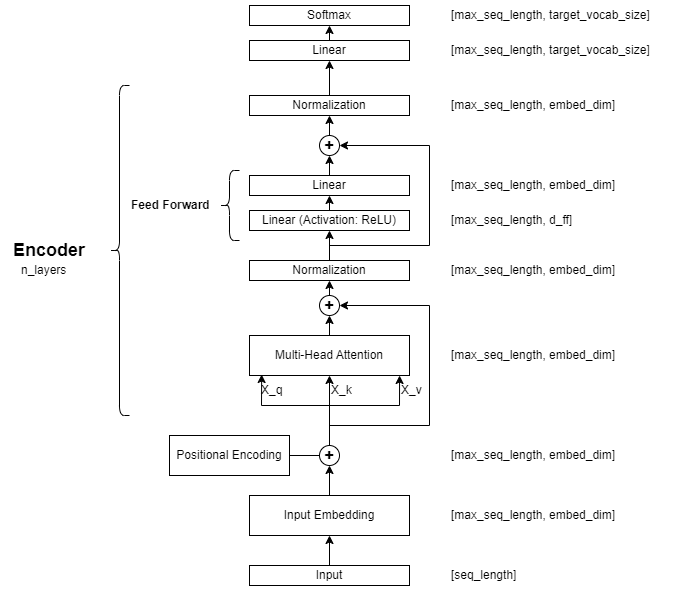

### Model Setup

In [9]:
src_vocab_size = vocab_size + 1  # adding padding token 0
tgt_vocab_size = vocab_size + 1
embed_dim = 512
max_seq_length = max_seq_length
n_heads = 8
n_layers = 1
d_ff = 2048
dropout_rate = 0.1
apply_mask = False

model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    embed_dim=embed_dim,
    max_seq_length=max_seq_length,
    n_heads=n_heads,
    n_layers=n_layers,
    d_ff=d_ff,
    dropout_rate=dropout_rate,
    apply_mask=apply_mask,
)

### Model Training

We train the model on train dataset and use cross entropy loss as objective function.

In [10]:
train_loss = model_training(model, train_data_loader, epochs=20, lr=1e-5, print_loss=True)

Epoch: 1, Loss: 1.8463116884231567
Epoch: 2, Loss: 1.626831293106079
Epoch: 3, Loss: 1.5165215730667114
Epoch: 4, Loss: 1.4740955829620361
Epoch: 5, Loss: 0.9810271859169006
Epoch: 6, Loss: 1.03404700756073
Epoch: 7, Loss: 0.9466716647148132
Epoch: 8, Loss: 1.0530587434768677
Epoch: 9, Loss: 0.9262719750404358
Epoch: 10, Loss: 0.7325530648231506
Epoch: 11, Loss: 0.7900456190109253
Epoch: 12, Loss: 0.7403037548065186
Epoch: 13, Loss: 0.6354010701179504
Epoch: 14, Loss: 0.6442050337791443
Epoch: 15, Loss: 0.6760815978050232
Epoch: 16, Loss: 0.7348865866661072
Epoch: 17, Loss: 0.5840985774993896
Epoch: 18, Loss: 0.5459777116775513
Epoch: 19, Loss: 0.6845058798789978
Epoch: 20, Loss: 0.6582540273666382


### Model Evaluation

We run the model on test dataset, and report the cross entropy loss.<br>
Besides, we also report prediction accuracy on token and sequence level.

In [11]:
out_test, loss = model_eval(model, input_test, target_test)
print("Test loss:", loss)

Test loss: 0.7026675939559937


In [12]:
# Target sequences
target_test

tensor([[3, 5, 1, 6, 6],
        [8, 5, 8, 4, 7],
        [5, 5, 6, 6, 4],
        ...,
        [5, 8, 3, 9, 0],
        [2, 1, 8, 9, 4],
        [1, 4, 6, 5, 4]])

In [13]:
# Predicted sequences
pred_test = torch.argmax(out_test, dim=-1)
pred_test

tensor([[3, 3, 1, 6, 6],
        [8, 8, 8, 7, 7],
        [5, 5, 6, 6, 4],
        ...,
        [5, 5, 8, 9, 0],
        [2, 1, 8, 9, 4],
        [1, 4, 4, 4, 4]], device='cuda:0')

In [14]:
print_accuracy(pred_test, target_test)

Report accuracy on token level
Number of wrong token predictions: 5657
Number of total token predictions: 17475
Token Accuracy: 67.6280%

Report accuracy on sequence level
Number of wrong sequence predictions: 3251
Number of total sequence predictions: 3495
Sequence Accuracy: 6.9814%


### Model Tuning

We use optuna and a validation dataset to tune the model for the following parameters (numbers in brackets are possible values):
- embed_dim: [256, 512, 1024, 2048]
- n_heads: [1, 2, 4, 8]
- n_layers: [1, 2, 4, 8]
- d_ff = [512, 1024, 2048, 4096]
- dropout_rate: [0, 0.1, 0.2, 0.3, 0.4, 0.5]
- apply_mask : [True, False]

We observe that the most impactful parameter is the number of encoders (<i>n_layers</i>). When <i>n_layers = 1</i>, the accuracy on token level on the test dataset is about 66% after 20 training epochs. When <i>n_layers = 4</i>, the accuracy is over 99%.

In [15]:
best_params = model_tuning(
        train_data_loader,
        input_val,
        target_val,
        vocab_size,
        max_seq_length,
        epochs=10,
        n_trials=30,
    )
print("Best params: ", best_params)

[I 2023-12-01 08:30:57,987] A new study created in memory with name: no-name-7554c383-bc46-462d-9e13-ef2e100ec6b5
[I 2023-12-01 08:31:19,182] Trial 0 finished with value: 0.7388737201690674 and parameters: {'embed_dim': 512, 'n_heads': 8, 'n_layers': 4, 'd_ff': 2048, 'dropout_rate': 0.4, 'apply_mask': True}. Best is trial 0 with value: 0.7388737201690674.
[I 2023-12-01 08:31:48,557] Trial 1 finished with value: 0.7194119095802307 and parameters: {'embed_dim': 256, 'n_heads': 4, 'n_layers': 8, 'd_ff': 1024, 'dropout_rate': 0, 'apply_mask': True}. Best is trial 1 with value: 0.7194119095802307.
[I 2023-12-01 08:31:54,399] Trial 2 finished with value: 1.208134651184082 and parameters: {'embed_dim': 256, 'n_heads': 2, 'n_layers': 1, 'd_ff': 1024, 'dropout_rate': 0.1, 'apply_mask': False}. Best is trial 1 with value: 0.7194119095802307.
[I 2023-12-01 08:32:13,287] Trial 3 finished with value: 1.0199381113052368 and parameters: {'embed_dim': 256, 'n_heads': 4, 'n_layers': 4, 'd_ff': 1024, 'd

Best params:  {'embed_dim': 1024, 'n_heads': 2, 'n_layers': 8, 'd_ff': 4096, 'dropout_rate': 0.3, 'apply_mask': False}


#### Model Setup with tuned parameters

In [16]:
model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    embed_dim=best_params["embed_dim"],
    max_seq_length=max_seq_length,
    n_heads=best_params["n_heads"],
    n_layers=best_params["n_layers"],
    d_ff=best_params["d_ff"],
    dropout_rate=best_params["dropout_rate"],
    apply_mask=best_params["apply_mask"],
)

#### Model Training with tuned parameters

In [17]:
train_loss = model_training(model, train_data_loader, epochs=20, lr=1e-5, print_loss=True)

Epoch: 1, Loss: 1.5765845775604248
Epoch: 2, Loss: 1.2758125066757202
Epoch: 3, Loss: 0.7459736466407776
Epoch: 4, Loss: 0.4431268274784088
Epoch: 5, Loss: 0.1554466187953949
Epoch: 6, Loss: 0.013323682360351086
Epoch: 7, Loss: 0.007814707234501839
Epoch: 8, Loss: 0.005584456026554108
Epoch: 9, Loss: 0.0032332586124539375
Epoch: 10, Loss: 0.0023247019853442907
Epoch: 11, Loss: 0.0026821154169738293
Epoch: 12, Loss: 0.0014540167758241296
Epoch: 13, Loss: 0.17802949249744415
Epoch: 14, Loss: 0.004901160020381212
Epoch: 15, Loss: 0.13879482448101044
Epoch: 16, Loss: 0.002519606612622738
Epoch: 17, Loss: 0.0016682054847478867
Epoch: 18, Loss: 0.0019328116904944181
Epoch: 19, Loss: 0.0010821718024089932
Epoch: 20, Loss: 0.0009244779357686639


#### Model Evaluation with tuned parameters

In [18]:
out_test, loss = model_eval(model, input_test, target_test)
print("Test loss:", loss)

Test loss: 0.00011462868860689923


In [19]:
# Target sequences
target_test

tensor([[3, 5, 1, 6, 6],
        [8, 5, 8, 4, 7],
        [5, 5, 6, 6, 4],
        ...,
        [5, 8, 3, 9, 0],
        [2, 1, 8, 9, 4],
        [1, 4, 6, 5, 4]])

In [20]:
# Predicted sequences
pred_test = torch.argmax(out_test, dim=-1)
pred_test

tensor([[3, 5, 1, 6, 6],
        [8, 5, 8, 4, 7],
        [5, 5, 6, 6, 4],
        ...,
        [5, 8, 3, 9, 0],
        [2, 1, 8, 9, 4],
        [1, 4, 6, 5, 4]], device='cuda:0')

In [21]:
print_accuracy(pred_test, target_test)

Report accuracy on token level
Number of wrong token predictions: 0
Number of total token predictions: 17475
Token Accuracy: 100.0000%

Report accuracy on sequence level
Number of wrong sequence predictions: 0
Number of total sequence predictions: 3495
Sequence Accuracy: 100.0000%


### Acknowledgement
We referenced the implementation of the vanilla transformer from [datacamp](https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch).